# Maxima finding algorithm recreated from implementation in Fiji (ImageJ)

This is a re-implementation of the java plugin written by Michael Schmid and Wayne Rasband for ImageJ. The original java code source can be found in: https://imagej.nih.gov/ij/developer/source/ij/plugin/filter/MaximumFinder.java.html
This implementation remains faithful to the original implementation but is not 100% optimised. The much faster cython version of the code can be found in the the notebook entitled find_maxima_cython.ipynb. This script is simply to provide the functionality of the ImageJ find maxima algorithm to individuals writing pure python script. 

### Functions and Dependencies

In [53]:
%pylab inline
from PIL import Image
from scipy import ndimage
import time
def isWithin(x, y, direction, width, height):
    #Depending on where we are and where we are heading, return the appropriate inequality.
    xmax = width - 1;
    ymax = height -1;
    if direction ==0:
        return (y>0);
    elif direction ==1:
            return (x<xmax and y>0);
    elif direction ==2:
            return (x<xmax);
    elif direction ==3:
            return (x<xmax and y<ymax);
    elif direction ==4:
            return (y<ymax);
    elif direction ==5:
            return (x>0 and y<ymax);
    elif direction ==6:
            return (x>0);
    elif direction ==7:
            return (x>0 and y>0);

    return False;  
def find_local_maxima(img_data):    
    globalMin = np.min(img_data)
    height = img_data.shape[0]
    width = img_data.shape[1]
    dir_x = [0,  1,  1,  1,  0, -1, -1, -1]
    dir_y = [-1, -1,  0,  1,  1,  1,  0, -1]
    out = np.zeros(img_data.shape)
    
    #Goes through each pixel
    for y in range(0,height):
        for x in range(0,width):
            #Reads in the img_data
            v = img_data[y,x]
            #If the pixel is local to the minima of the whole image, can't be maxima.
            if v == globalMin:
                continue
            
            #Is a maxima until proven that it is not.
            isMax = True
            isInner = (y!=0 and y!=height-1) and (x!=0 and x!=width-1)
            for d in range(0,8):
                #Scan each pixel in neighbourhood
                if isInner or isWithin(x,y,d,width,height):
                    #Read the pixels in the neighbourhood.
                    vNeighbour = img_data[y+dir_y[d],x + dir_x[d]]
                    if vNeighbour >v:
                        #We have found there is larger pixel in the neighbourhood.
                        #So this cannot be a local maxima.
                        isMax = False
                        break
            if isMax:
                out[y,x] = 1
    return out
def find_local_maxima_np(img_data):
    #This is the numpy/scipy version of the above function (find local maxima).
    #Its a bit faster, and more compact code.
    
    #Filter data with maximum filter to find maximum filter response in each neighbourhood
    max_out = ndimage.filters.maximum_filter(img_data,size=3)
    #Find local maxima.
    local_max = np.zeros((img_data.shape))
    local_max[max_out == img_data] = 1
    local_max[img_data == np.min(img_data)] = 0
    return local_max


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Main script for maxima finding (partially optimised)
Literal translation of the ImageJ find maxima plugin with a few tweaks to make it more numpy pythonic

count 120
time: 7.6345 s


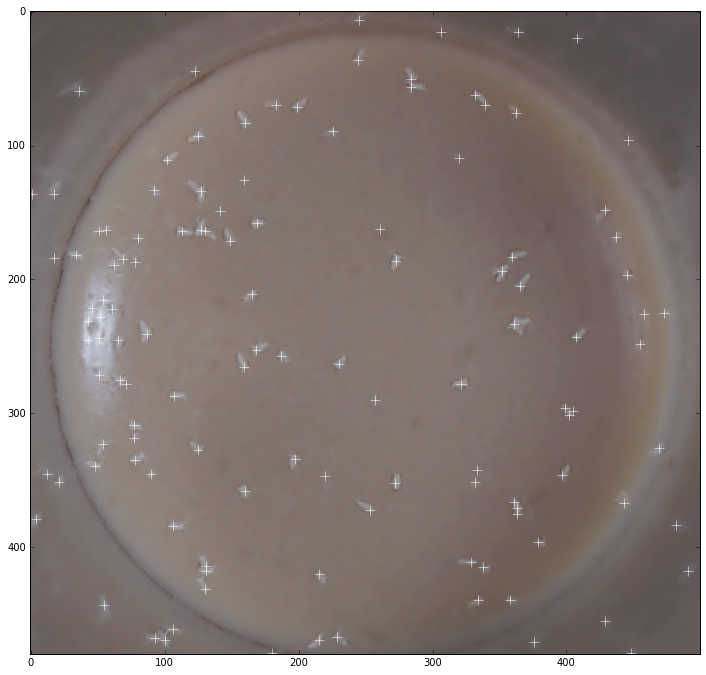

In [143]:
img = Image.open('002eggs.png')
ntol = 10 #Noise Tolerance.


#Start of script
t1 = time.time()
img_data = np.array(img)

#Should your image be an RGB image.
if img_data.shape >2:
    img_data = (np.sum(img_data,2)/3.0)
    
if np.max(img_data) >255 or np.min(img_data)<0:
    print 'warning: your image should be scaled between 0 and 255 (8-bit).'

#Finds the local maxima using maximum filter.
local_max = find_local_maxima_np(img_data)

#Find local maxima coordinates
ypts, xpts = np.where(local_max == 1)
#Find the corresponding intensities
ipts = img_data[ypts,xpts]

#Changes order from max to min.
ind_pts = np.argsort(ipts)[::-1]
ypts = ypts[ind_pts]
xpts = xpts[ind_pts]
ipts = ipts[ind_pts]


#Create our variables and allocate memory for speed.
types = np.array(local_max).astype(np.int8)
pListx = np.zeros((img_data.shape[0]*img_data.shape[1]))
pListy = np.zeros((img_data.shape[0]*img_data.shape[1]))
width = img_data.shape[1]
height = img_data.shape[0]

#This defines the pixel neighbourhood 8-connected neighbourhood [3x3]
dir_x = [0,  1,  1,  1,  0, -1, -1, -1]
dir_y = [-1, -1,  0,  1,  1,  1,  0, -1]

#At each stage we classify our pixels. We use 2n as we can use more than one definition
#together.
MAXIMUM = 1
LISTED = 2
PROCESSED = 4
MAX_AREA = 8
EQUAL = 16
MAX_POINT = 32
ELIMINATED = 64

maxSortingError = 0
time_array =[]
#Now we iterate through each of a local maxima and prune the sub-maximal peaks.
#This extends the neighbourhood and combines and prunes away unwanted maxima using the
#noise tolerance to decide what counts and what doesn't
for y0, x0, v0 in zip(ypts, xpts, ipts):

    if (types[y0,x0]&PROCESSED) !=0:
        #If processed already then skip this pixel, it won't be maxima.
        continue
    
    
    sortingError = True
    while sortingError == True:
        
        #Our initial pixel 
        pListx[0] = x0
        pListy[0] = y0
        types[y0,x0] |= (EQUAL|LISTED) #Listed and Equal
        
        
        listlen = 1
        listI = 0
        
        #isEdgeMAxima = (x0==0 or x0 == width-1 or y0 == 0 or y0 == height -1)
        sortingError = False
        maxPossible = True
        xEqual = float(x0)
        yEqual = float(y0)
        nEqual = 1.0
        
        while listI < listlen:
            #We iteratively add points. This loop will keep going until we have
            #exhausted the neighbourhood.
            
            #Collect the next point to consider
            x = pListx[listI]
            y = pListy[listI]
            
            #Is our point legal. //not necessary, but faster than isWithin.
            #With subsequent 'OR' statement the first arguement is evaluated
            #and then only the second if the first is false.
            isInner = (y != 0 and y != height -1) and (x!=0 and x != width-1)
            
            t3 = time.time()
            for d in range(0,8):
                #Scan the neighbourhood.
                x2 = int(x+dir_x[d])
                y2 = int(y+dir_y[d])
                
                
                if (isInner or isWithin(x,y,d,width,height)) and (types[y2,x2]&LISTED) ==0:
                    #If the pixel is located legally
                    
                    
                    if types[y2,x2]&PROCESSED !=0:
                        #If the pixel is processed already. It won't be maxima.
                        maxPossible = False
                        break;
                    
                    v2 = img_data[y2,x2] #return pixel from neighbourhood.
                    
                    if v2 > v0 + maxSortingError:
                        #We have reached a higher maximum.
                        maxPossible = False
                        break;
                    
                    elif v2 >= v0 - ntol:
                        
                        #If equal or within we add it on.
                        pListx[listlen] = x2
                        pListy[listlen] = y2
                        listlen = listlen+1
                        #We mark it as listed. Because its in our list :-).
                        types[y2,x2] |= LISTED
                        
                        
                        #We are not excluding edge pixels yet.
                        #if (x2==0 or x2 == width-1 or y2==0 or y2==height-1):
                        #    isEdgeMaximum = True
                            
                            #maxPossible = False
                            #break

                        if v2==v0:
                            
                            #This point is equal to our maxima.
                            types[y2,x2] |= EQUAL
                            #We have to merge the coordinates.
                            xEqual += x2
                            yEqual += y2
                            nEqual += 1
            listI +=1
            t4 = time.time()
            time_array.append(t4-t3)
        #if sortingError:
            #If our point x0, y0 was not true maxima and we reach a bigger one, start again.
            #for listI in range(0,Listlen):
        #   types[pListy[0:listlen],pListx[0:listlen]] =0
        #else:
        if maxPossible == True:
            resetMask = ~(LISTED)
        else:
            resetMask = ~(LISTED|EQUAL)

        #Now we calculate the x and y-coordinates, if there were any equal.
        xEqual /= nEqual
        yEqual /= nEqual
        minDist2 = 1e20
        nearestI = 0

        #This makes sure it has same output as the fiji plugin. Not strictly needed.
        xEqual = round(xEqual)
        yEqual = round(yEqual)

        x = pListx[0:listlen].astype(np.int32)
        y = pListy[0:listlen].astype(np.int32)
        types[y,x] &= resetMask
        types[y,x] |= PROCESSED



        if maxPossible:
            types[y,x] |= MAX_AREA

            #This is where we assign the actual maxima location.
            dv =  (types[y,x]&EQUAL) !=0
            dist2 = (xEqual-x[dv]).astype(np.float64)**2+(yEqual-y[dv]).astype(np.float64)**2

            indx = np.arange(0,listlen)
            rd_indx = indx[dv]
            nearestI = rd_indx[np.argmin(dist2)]

            x = int(pListx[nearestI])
            y = int(pListy[nearestI])
            types[y,x] |= MAX_POINT
            
                
                   
            
                        
                
out = types==61
ypts,xpts = np.where(out)
t2 = time.time()
print("count "+str(np.sum(out)))
print("time: "+str(np.round(t2-t1,4))+' s')

figsize(12,12)
plot(xpts,ypts,'w+',markersize=10)
imshow(img)

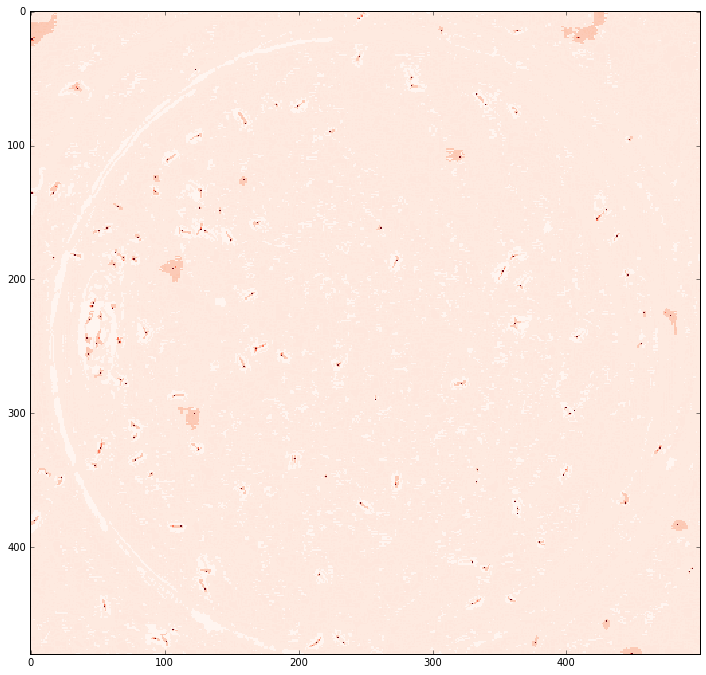

In [139]:
#This image shows the pixel classification output by the script.
imshow(types,interpolation='nearest',cmap='Reds')